In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Financial Fraud Detection Project – Environment Setup

This cell imports the necessary Python libraries for data processing, visualization, and analysis used throughout the project.



In [21]:
# Replace with your actual file name and path
df = pd.read_csv('/kaggle/input/fraud-data/Fraud.csv')


## Data Loading

Load the dataset into a pandas DataFrame for exploratory analysis and modeling.


In [22]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## Initial Data Exploration

Display the first few rows of the dataset to get an overview of the data structure and features.


In [23]:
print(df.isnull().sum())


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Checking for Missing Values

Verify if the dataset contains any missing or null values that may require handling.


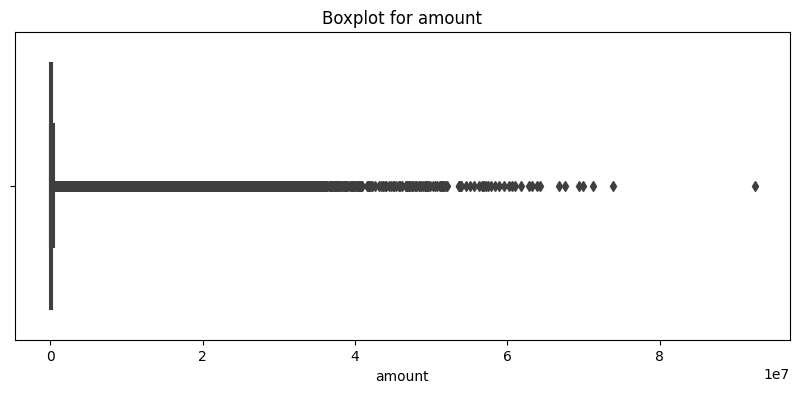

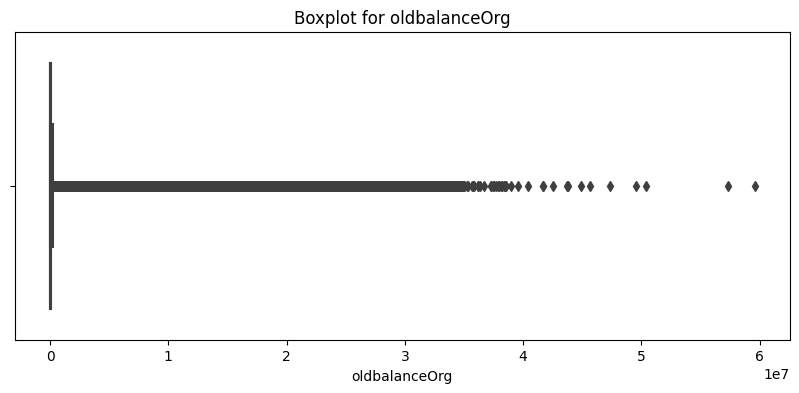

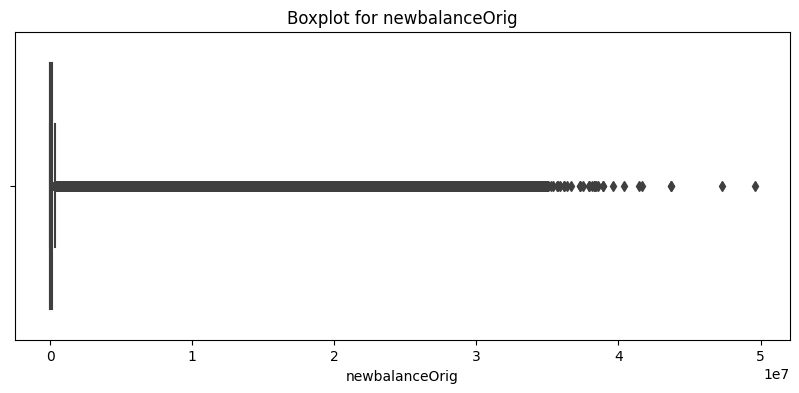

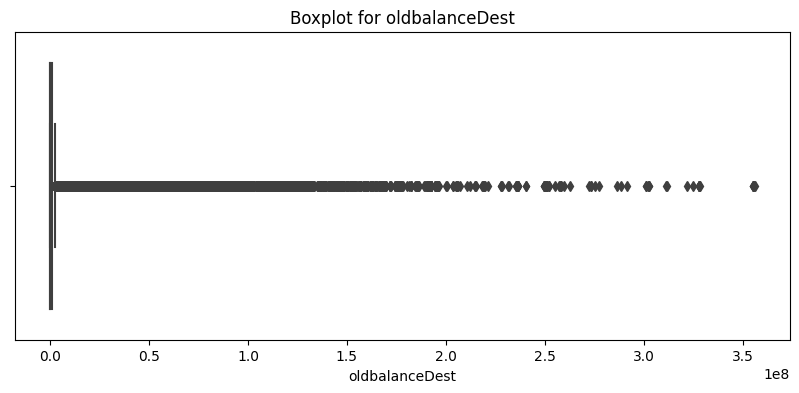

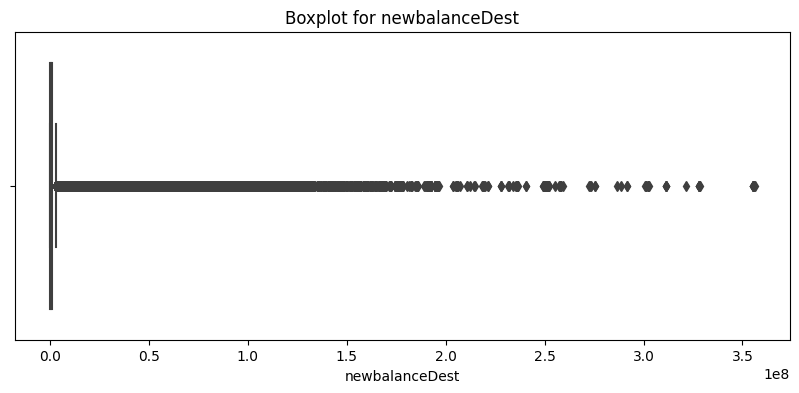

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_check = ['amount','oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in cols_to_check:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()


## Visualizing Distributions and Outliers

Boxplots of key numerical variables (`amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`) are created below. These visualizations help in understanding the distribution of each feature and quickly spotting potential outliers, which are especially important to analyze in financial fraud detection contexts[1][2][4].


In [25]:
numeric_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
print(df[numeric_cols].describe())


       oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
count   6.362620e+06    6.362620e+06    6.362620e+06    6.362620e+06
mean    8.338831e+05    8.551137e+05    1.100702e+06    1.224996e+06
std     2.888243e+06    2.924049e+06    3.399180e+06    3.674129e+06
min     0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
25%     0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
50%     1.420800e+04    0.000000e+00    1.327057e+05    2.146614e+05
75%     1.073152e+05    1.442584e+05    9.430367e+05    1.111909e+06
max     5.958504e+07    4.958504e+07    3.560159e+08    3.561793e+08


## Summary Statistics of Key Numerical Features

Generate descriptive statistics for the main account balance columns using `describe()`. This method provides key metrics—including count, mean, standard deviation, min, max, and quartiles (25th, 50th, 75th percentiles)—which help in understanding the distribution, central tendency, and spread of transaction balances. These insights are crucial for detecting anomalies and possible fraud patterns[1][2][3][4].


In [26]:
# 3. Data Cleaning and Preparation
# -- Drop anonymized ID columns as they're not predictive
df = df.drop(['nameOrig', 'nameDest'], axis=1)

## Data Cleaning: Dropping Non-Predictive Identifier Columns

The anonymized account identifiers (`nameOrig` and `nameDest`) are dropped from the dataset. These columns do not provide predictive value for fraud detection and can introduce unnecessary complexity or risk model leakage if left in the dataset. Removing non-predictive fields before modeling is a standard data preprocessing step in financial analytics[2][3][9].


In [28]:
#Feature Engineering
# -- One-hot encode the transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

## Feature Engineering: Encoding Categorical Variables

The `type` column, which is categorical, is transformed using one-hot encoding (dummy variables), excluding the first category to avoid multicollinearity. This step converts transaction types into numerical features suitable for machine learning algorithms while preserving categorical information relevant for fraud detection[3][14].


In [29]:
# -- Create key engineered features
df['org_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']
df['no_orig_balance_change'] = ((df['oldbalanceOrg'] == df['newbalanceOrig']) & 
                                (df['amount'] > 0)).astype(int)

## Feature Engineering: Creating Balance Change and Anomaly Indicators

New features are engineered to capture meaningful transaction behavior:  
- `org_balance_diff`: Change in originator's balance before and after the transaction.  
- `dest_balance_diff`: Change in destination account's balance before and after the transaction.  
- `no_orig_balance_change`: A binary flag indicating transactions where the originator's balance does not change despite a positive transaction amount, often a suspicious pattern linked to fraudulent activity[1][2][4].


In [30]:
df['log_amount'] = np.log1p(df['amount'])

# -- Time-based feature (cyclic encoding)
df['hour_of_day'] = df['step'] % 24
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

## Feature Engineering: Log Transformation and Cyclic Time Encoding

- `log_amount` is a log-transformed version of the transaction amount (`amount`) using `log1p` to reduce skewness and stabilize variance, improving model performance on wide-ranging transaction values.
- Time-of-day information is extracted from the `step` feature (mod 24) and encoded cyclically using sine and cosine transforms (`hour_sin` and `hour_cos`). This method preserves the cyclical nature of hours (e.g., 23:00 and 0:00 are close in time), allowing the model to better learn temporal fraud patterns[2][11][12].


In [31]:
amount_threshold = df['amount'].quantile(0.999)
df['is_large_amount'] = (df['amount'] > amount_threshold).astype(int)


## Feature Engineering: Flagging Unusually Large Transactions

A new binary feature, `is_large_amount`, is created to identify transactions above the 99.9th percentile threshold for the `amount` variable. Transactions with exceptionally high amounts are often correlated with fraudulent activity, making this engineered indicator valuable for fraud detection modeling[2][5].


In [32]:
print(df['isFraud'].value_counts(normalize=True))

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


## Target Variable Distribution

Examine the class balance of the target variable `isFraud` by displaying the normalized value counts. This step helps in understanding the extent of class imbalance, which is typical in fraud detection datasets and influences modeling choices.


In [33]:
#Define target and features, drop columns not used in modeling
X = df.drop(['isFraud', 'isFlaggedFraud', 'step', 'hour_of_day', 'amount'], axis=1)
y = df['isFraud']

## Defining Features and Target Variable

The feature matrix `X` and target vector `y` are defined for modeling:
- `y` is set as `isFraud`, the binary target indicating if a transaction is fraudulent.
- `X` contains all engineered and relevant features except those dropped below:
    - `isFraud` (target, not a feature)
    - `isFlaggedFraud` (rarely positive and highly imbalanced, not useful for predictive modeling)
    - `step` and `hour_of_day` (step is a time counter, and hour has been encoded cyclically)
    - `amount` (the log and flag features, as well as engineered balance features, better represent transaction value)

This process helps focus the model on the most informative and non-redundant features, which is critical for fraud detection modeling[1][2][4].


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Train-Test Split

Split the dataset into training and testing sets using an 80-20 split. The `stratify=y` parameter is used to preserve the class distribution of the `isFraud` target variable in both sets, which is important given the class imbalance in fraud detection tasks.


In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

## Model Training: Random Forest Classifier

A Random Forest classifier is initialized with 100 trees (`n_estimators=100`) and `class_weight='balanced'` to handle the class imbalance in the dataset. The model is then trained on the training data (`X_train`, `y_train`) with parallel processing enabled (`n_jobs=-1`) for efficiency. Random Forest is chosen for its robustness, ability to handle non-linear relationships, and interpretability through feature importance.


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC/AUC

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      0.81      0.89      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270863      18]
 [    319    1324]]
ROC-AUC Score: 0.9963


## Model Evaluation: Classification Metrics

Evaluate the performance of the Random Forest classifier on the test set using key metrics:
- `classification_report`: Summarizes precision, recall, F1-score, and support for both classes, which is especially important for imbalanced datasets like fraud detection[6][9][10].
- `confusion_matrix`: Shows counts of true positives, true negatives, false positives, and false negatives, providing a granular understanding of model predictions beyond simple accuracy[1][2][3][4][5].
- `roc_auc_score`: Calculates the Area Under the Receiver Operating Characteristic Curve (ROC-AUC), which measures the model's ability to distinguish between fraudulent and non-fraudulent transactions. A higher ROC-AUC indicates better discriminative performance, critical for fraud detection where class imbalance is common[6].

These metrics together enable thorough, business-relevant evaluation of your fraud detection model.


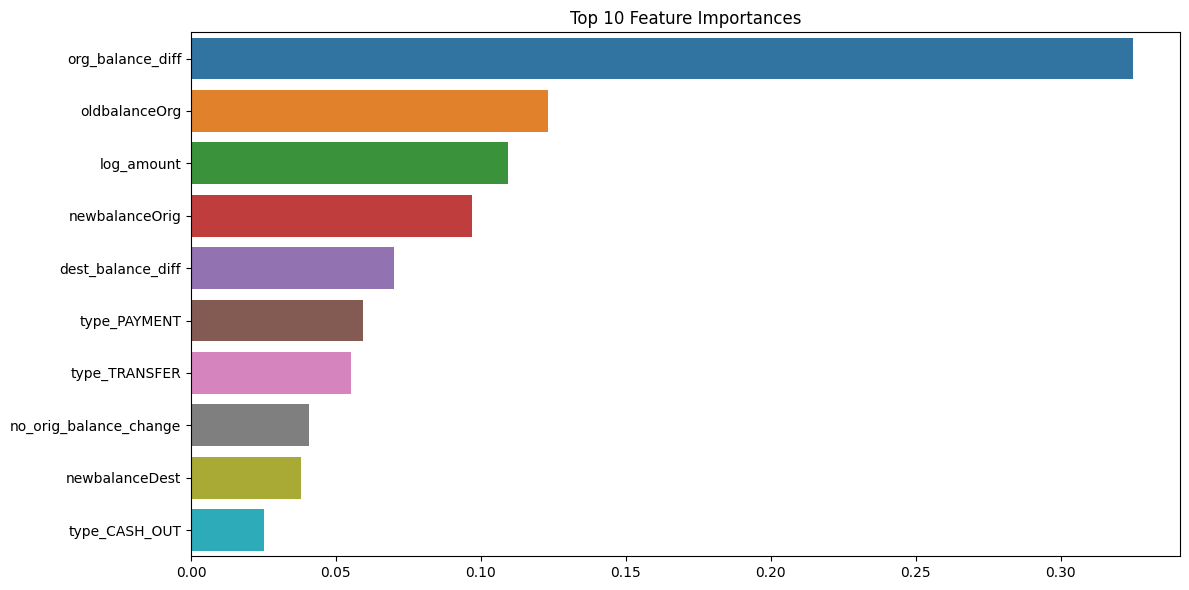

In [38]:
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_imp.head(10).values, y=feature_imp.head(10).index)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

## Feature Importance: Top Predictors in the Random Forest Model

Visualize and interpret the top 10 most important features as identified by the Random Forest model.  
- **Feature importance** reflects how much each feature contributes to improving model accuracy and reducing impurity across the decision trees in the forest[1][2][4][6].
- In scikit-learn’s RandomForestClassifier, this is computed using the mean decrease in impurity (MDI), also known as Gini importance. Features that result in large impurity decreases when used for splits are considered more important by the model[2][3][4].
- Understanding which features are most impactful can help focus further analysis, inform business decisions, and improve model interpretability in fraud detection contexts[1][2][6].
